# Load and analyze results from passive stimulus experiments

* Prior to receiving any behavior training, head fixed mice were exposed to three stimulus conditions in randomized order:
    * Full screen, square wave gratings, flashed for 200 ms ("visual" condition)
    * White noise bursts, 200 ms duration ("auditory" condition)
    * Concurrent gratings/white noise bursts ("visual_and_auditory" condition)
* Each experiment was 10-15 minutes in length with ~50 presentations per condition


## Imports
* The `visual_behavior_research` package spun off of the main `visual_behavior_analysis` package and contains code for processing Inscopix data (https://github.com/AllenInstitute/visual_behavior_research/tree/master/visual_behavior_research)
* Functions written specifically for this analysis are in .fig2_helper_functions.py

In [36]:
import visual_behavior_research.utilities as vbu
import visual_behavior_research.plotting as vbp
import visual_behavior_research.projects.tbd.database_utilities as du
import visual_behavior_research.projects.tbd.utilities as tbdu

from visual_behavior_research.projects.tbd.session import Session

import fig2_helper_functions
import isx

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
responsiveness_window = 1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'

## load summary data

In [3]:
summary = tbdu.get_db_table('summary')
mice_table = tbdu.get_db_table('mice')

In [4]:
mice_table

,mouse_id,genotype,anterior_or_posterior,AP_coord,ML_coord,DV_coord,basefolder,id
0,M332849,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,anterior,1.5,3.125,2.50,//olsenlab1/data/endoscope_imaging/M332849,1
1,M334410,Gnb4-IRES2-Cre;AAV-GCaMP6s,anterior,1.5,2.625,2.50,//olsenlab1/data/endoscope_imaging/M334410,2
2,M334412,Gnb4-IRES2-Cre;AAV-GCaMP6s,anterior,1.5,2.625,2.70,//olsenlab1/data/endoscope_imaging/M334412,4
3,M335379,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,anterior,1.5,3.125,2.50,//olsenlab1/data/endoscope_imaging/M335379,5
4,M339255,Gnb4-IRES2-Cre;AAV-GCaMP6s,anterior,1.5,2.625,2.70,//olsenlab1/data/endoscope_imaging/M339255,6
5,M340049,Gnb4-IRES2-Cre;AAV-GCaMP6s,posterior,0.0,4.000,3.10,//olsenlab1/data/endoscope_imaging/M340049,7
6,M340050,Gnb4-IRES2-Cre;AAV-GCaMP6s,posterior,0.0,4.000,3.10,//olsenlab1/data/endoscope_imaging/M340050,8
7,M348126,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,anterior,1.5,2.625,2.50,//olsenlab1/data/endoscope_imaging/M348126,9
8,M351181,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,anterior,1.5,2.625,2.50,//olsenlab1/data/endoscope_imaging/M351181,10
9,M375765,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,anterior,1.5,2.625,2.50,//olsenlab1/data/endoscope_imaging/M375765,11


In [5]:
def get_gender(mouse_id):
    mouse_info = vbu.query_labtracks(mouse_id)
    return mouse_info['sex']

### get sessions marked as 'passive_stim' that are good for analysis

In [6]:
all_passive = summary[
    (summary['experiment_type'] == 'passive_stim')
    &(summary['good_for_analysis']!='False')
#     &(summary['anterior_or_posterior']=='anterior')
].copy().sort_values(by=['mouse_id','experiment_type'])

# merge in lens location data from mouse table 
all_passive = all_passive.merge(mice_table[['mouse_id','anterior_or_posterior', 'AP_coord', 'ML_coord', 'DV_coord']],on='mouse_id').sort_values(by='recording_date')

# keep only anterior sessions:
all_passive = all_passive[
    (all_passive['anterior_or_posterior']=='anterior')
]

# keep only last experiment for each mouse (in some cases we repeated passive stim experiments)
all_passive = all_passive[all_passive[['mouse_id']].duplicated(keep='last')==False].reset_index()

# add a genotype shorthand column for display
all_passive['genotype_shorthand'] = all_passive['genotype'].map(lambda x:fig2_helper_functions.get_genotype_shorthand(x))

# sort and reset indices
sessions_to_analyze = all_passive.sort_values(by=['genotype','anterior_or_posterior']).reset_index()

sessions_to_analyze['sex'] = sessions_to_analyze['mouse_id'].map(lambda mid:get_gender(mid.lstrip('M')))
cols_to_display = ['genotype_shorthand','genotype','mouse_id','AP_coord', 'ML_coord', 'DV_coord','sex', 'number_accepted_cells','full_path']

sessions_to_analyze[cols_to_display]

,genotype_shorthand,genotype,mouse_id,AP_coord,ML_coord,DV_coord,sex,number_accepted_cells,full_path
0,Gnb4-Cre;AAB-GCaMPs,Gnb4-IRES2-Cre;AAV-GCaMP6s,M334410,1.5,2.625,2.5,M,72.0,//olsenlab1/data/endoscope_imaging/M334410/201...
1,Gnb4-Cre;AAB-GCaMPs,Gnb4-IRES2-Cre;AAV-GCaMP6s,M334412,1.5,2.625,2.7,M,146.0,//olsenlab1/data/endoscope_imaging/M334412/201...
2,Gnb4-CreERT2;Ai148,Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA...,M406494,1.5,2.625,2.5,F,20.0,//olsenlab1/data/endoscope_imaging/M406494/201...
3,Gnb4-CreERT2;Ai93,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,M332849,1.5,3.125,2.5,M,11.0,//olsenlab1/data/endoscope_imaging/M332849/201...
4,Gnb4-CreERT2;Ai93,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,M397408,1.5,2.625,2.5,F,17.0,//olsenlab1/data/endoscope_imaging/M397408/201...
5,Gnb4-CreERT2;Ai93,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,M375765,1.5,2.625,2.5,M,10.0,//olsenlab1/data/endoscope_imaging/M375765/201...
6,Gnb4-CreERT2;Ai93,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,M416531,1.5,3.125,2.5,F,61.0,//olsenlab1/data/endoscope_imaging/M416531/201...
7,Gnb4-CreERT2;Ai93,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,M432805,1.0,3.125,2.0,M,45.0,//olsenlab1/data/endoscope_imaging/M432805/201...
8,Gnb4-CreERT2;Ai94,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,M335379,1.5,3.125,2.5,M,130.0,//olsenlab1/data/endoscope_imaging/M335379/201...
9,Gnb4-CreERT2;Ai94,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,M351181,1.5,2.625,2.5,F,118.0,//olsenlab1/data/endoscope_imaging/M351181/201...


In [7]:
cols_to_display = ['genotype_shorthand','genotype','mouse_id','AP_coord', 'ML_coord', 'DV_coord','sex']
sessions_to_analyze[cols_to_display].to_csv('/home/dougo/tbd_imaging_mouse_list_2020.09.22.csv', index=False)

In [8]:
sessions_to_analyze['genotype'].value_counts()

Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    5
Gnb4-IRES2-Cre;AAV-GCaMP6s                                   2
Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-GCaMP6s)/wt    2
Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt          1
Name: genotype, dtype: int64

### load each mouse's session data into a dictionary called 'session' with mouse_id as key
This uses code in `visual_behavior_research` to build a dedicated session object with many associated methods and attributes

In [9]:
session = {}
for idx,row in sessions_to_analyze.iterrows():
    session[row['mouse_id']] = fig2_helper_functions.load_session(row['full_path'], load_cached_traces_table=True)
    print('on session {} of {}'.format(idx+1,len(sessions_to_analyze)),end='\r')

### Apply inclusion criteria to cells in the dataset
* keep cells with an SNR above 5 or the 95th percentile of identified peaks in the z-scored data exceeding 5 SDs
  * the latter metric captures responses with low SNR due to [apparent] failures in the Inscopix event detection algorithm
* keep cells that have not been labeled as 'likely repeats'

In [10]:
mice = session.keys()

for mouse in mice:
    # get metrics dataframe
    metrics = session[mouse].metrics
    # apply filters, get names of cells to keep
    cells_to_keep = metrics[
#         ((metrics['snr']>5) | (metrics['peak_95th_percentile']>5)) # use either the SNR or the peak 95th percentile metric
        (metrics['snr']>3)
        &(metrics['likely_repeat']==False) # exclude repeats
    ].reset_index()['cellName']
    # save the list of cells to keep as an attribute of the session object
    session[mouse].filtered_cell_IDs = cells_to_keep.values

### Look at some example cells:

#### a cell with a high SNR

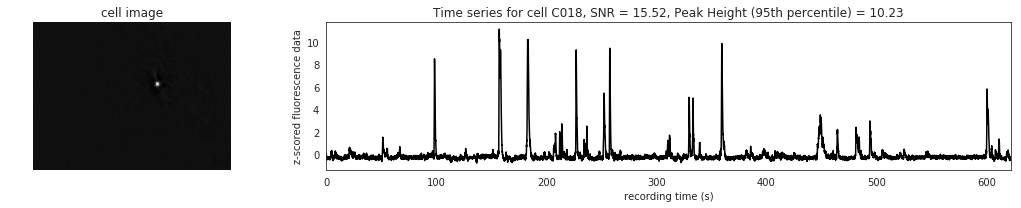

In [11]:
mouse = 'M351181'
cell = 'C018'
fig2_helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

#### a cell with a low SNR but a large peaks (the detected events from the Inscopix event detection algorithm don't correspond to the peaks)

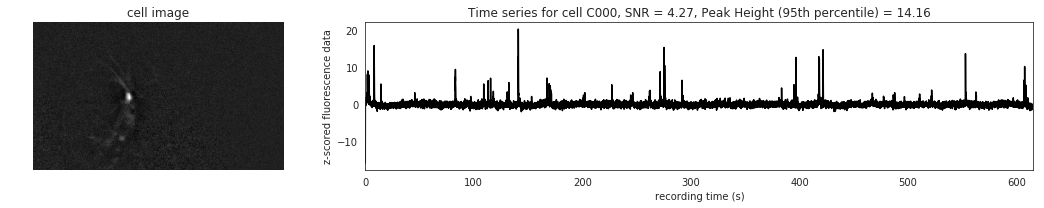

In [12]:
mouse = 'M432805'
cell = 'C000'
fig2_helper_functions.plot_cell(session[mouse],cell)

#### a cell with low SNR

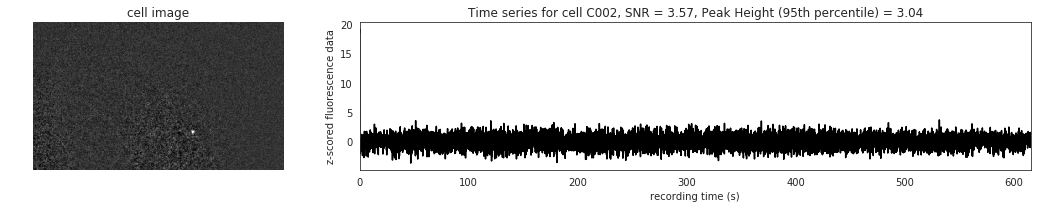

In [13]:
mouse = 'M432805'
cell = 'C002'
fig2_helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

#### However, even an SNR near 5 doesn't guarantee clean calcium transients. It's possible that a higher threshold should be applied to be more conservative.

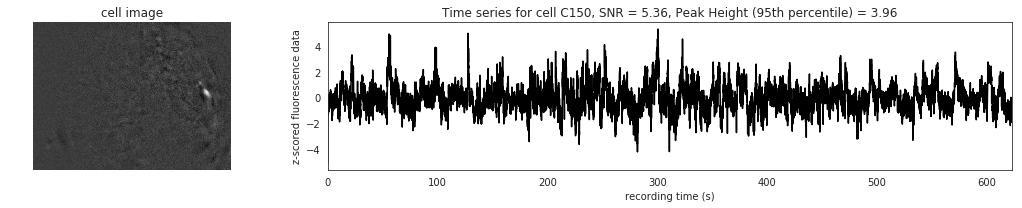

In [14]:
mouse = 'M351181'
cell = 'C150'
fig2_helper_functions.plot_cell(session[mouse],cell,timeseries_type='filtered')

### I'm also filtering out cells that look to be repeats due to over-segmentation

In [15]:
mouse = 'M351181'
session[mouse].repeat_roi_analysis.pairwise_cell_metrics.query('likely_repeat == True')

,correlation coefficient,distance between cell centers (pixels),structural similarity metric,cell_ids,log_distance,likely_repeat,cell_1,cell_2,cell_1_snr,cell_2_snr,cell_to_exclude,color
2277,0.991916,4.242641,0.335286,C080xC079,1.445186,True,C080,C079,25.29180,24.0847,C079,red
3159,0.970219,3.605551,0.336693,C098xC097,1.282475,True,C098,C097,17.47610,12.5571,C097,red
3314,0.908061,5.000000,0.045489,C101xC093,1.609438,True,C101,C093,8.24822,11.6901,C101,red


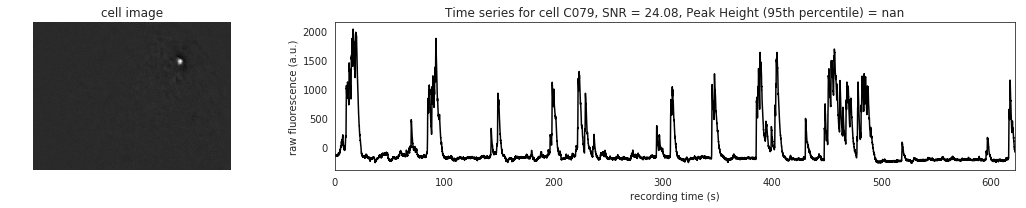

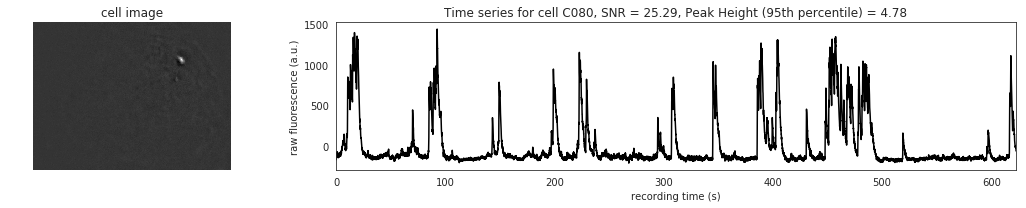

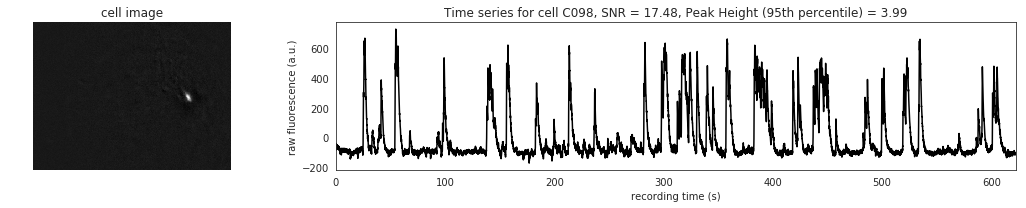

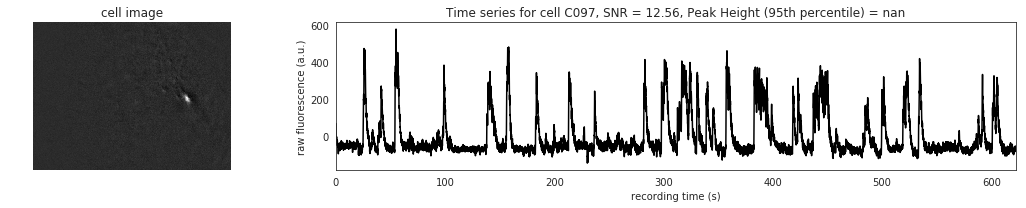

In [16]:
mouse = 'M351181'
fig2_helper_functions.plot_cell(session[mouse],cell='C079',timeseries_type='raw')
fig2_helper_functions.plot_cell(session[mouse],cell='C080',timeseries_type='raw')

fig2_helper_functions.plot_cell(session[mouse],cell='C098',timeseries_type='raw')
fig2_helper_functions.plot_cell(session[mouse],cell='C097',timeseries_type='raw')

### Here is the summary of sessions and cell counts before/after filtering (sessions with incomplete data aren't included)

In [17]:
sessions_to_analyze

,level_0,index,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,...,full_path,recording_date,processing_date,summarized,anterior_or_posterior,AP_coord,ML_coord,DV_coord,genotype_shorthand,sex
0,1,5,69,//olsenlab1/data/endoscope_imaging,None,2017.10.27_M334410_visual_auditory_stimuli_10m...,Gnb4-IRES2-Cre;AAV-GCaMP6s,None,None,None,...,//olsenlab1/data/endoscope_imaging/M334410/201...,2017-10-27 10:57:47.469000,2018-12-14 01:47:16.329248905-08:00,True,anterior,1.5,2.625,2.5,Gnb4-Cre;AAB-GCaMPs,M
1,4,8,110,//olsenlab1/data/endoscope_imaging,None,2018.02.21_M334412_passive-stim,Gnb4-IRES2-Cre;AAV-GCaMP6s,None,None,None,...,//olsenlab1/data/endoscope_imaging/M334412/201...,2018-02-21 17:36:40.068000,2019-01-12 04:17:24.670338392-08:00,True,anterior,1.5,2.625,2.7,Gnb4-Cre;AAB-GCaMPs,M
2,8,14,202,//olsenlab1/data/endoscope_imaging,None,2019.03.25_passive-stim_2,Gnb4-IRES2-CreERT2/wt;Ai148(TIT2L-GC6f-ICL-tTA...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M406494/201...,2019-03-25 15:10:42.239000,2019-03-26 00:37:22.994131088-07:00,True,anterior,1.5,2.625,2.5,Gnb4-CreERT2;Ai148,F
3,2,0,65,//olsenlab1/data/endoscope_imaging,None,2017.11.07_M332849_visual_auditory_stimuli_10m...,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M332849/201...,2017-11-07 11:30:45.905000,2018-12-13 23:35:08.291905165-08:00,True,anterior,1.5,3.125,2.5,Gnb4-CreERT2;Ai93,M
4,5,13,60,//olsenlab1/data/endoscope_imaging,None,20180920_M397408_passive_stim,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M397408/201...,2018-09-20 10:38:25.280000,2018-10-01 14:26:59.043725014-07:00,True,anterior,1.5,2.625,2.5,Gnb4-CreERT2;Ai93,F
5,6,12,72,//olsenlab1/data/endoscope_imaging,None,20180920_M375765_passive_stim,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M375765/201...,2018-09-20 12:42:49.962000,2018-12-14 03:37:29.648535967-08:00,True,anterior,1.5,2.625,2.5,Gnb4-CreERT2;Ai93,M
6,7,15,213,//olsenlab1/data/endoscope_imaging,None,2019.03.25_passive-stim,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M416531/201...,2019-03-25 14:22:21.518000,2019-03-26 01:21:12.827245235-07:00,True,anterior,1.5,3.125,2.5,Gnb4-CreERT2;Ai93,F
7,9,18,246,//olsenlab1/data/endoscope_imaging,None,2019.06.11_passive_stim,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M432805/201...,2019-06-11 17:23:22,2019-06-12 12:44:31.709861040-07:00,True,anterior,1.0,3.125,2.0,Gnb4-CreERT2;Ai93,M
8,0,9,70,//olsenlab1/data/endoscope_imaging,None,2017.10.24_M335379_visual_auditory_stimuli_10m...,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M335379/201...,2017-10-24 15:57:58.264000,2018-12-14 02:24:22.327345610-08:00,True,anterior,1.5,3.125,2.5,Gnb4-CreERT2;Ai94,M
9,3,11,66,//olsenlab1/data/endoscope_imaging,None,2018.02.16_M351181_VisAudStim_10min_day2,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,None,None,None,...,//olsenlab1/data/endoscope_imaging/M351181/201...,2018-02-16 12:48:23.809000,2018-12-14 00:12:11.677001715-08:00,True,anterior,1.5,2.625,2.5,Gnb4-CreERT2;Ai94,F


In [18]:
sessions_to_analyze['cell_count_post_filtering'] = sessions_to_analyze['mouse_id'].map(lambda x:len(session[x].filtered_cell_IDs))
sessions_to_analyze.set_index('mouse_id',inplace=True)
cols_to_display = ['genotype_shorthand','anterior_or_posterior','number_accepted_cells','cell_count_post_filtering']
sessions_to_analyze[cols_to_display]

,genotype_shorthand,anterior_or_posterior,number_accepted_cells,cell_count_post_filtering
mouse_id,,,,
M334410,Gnb4-Cre;AAB-GCaMPs,anterior,72.0,69
M334412,Gnb4-Cre;AAB-GCaMPs,anterior,146.0,144
M406494,Gnb4-CreERT2;Ai148,anterior,20.0,19
M332849,Gnb4-CreERT2;Ai93,anterior,11.0,11
M397408,Gnb4-CreERT2;Ai93,anterior,17.0,17
M375765,Gnb4-CreERT2;Ai93,anterior,10.0,10
M416531,Gnb4-CreERT2;Ai93,anterior,61.0,61
M432805,Gnb4-CreERT2;Ai93,anterior,45.0,46
M335379,Gnb4-CreERT2;Ai94,anterior,130.0,127


## for each session, calculate responsiveness data for each accepted cell
extract the integral of the z-scored response in the <responsiveness_window> second(s) before and after each stimulus presentation

In [19]:
for mouse_id in mice:
    session[mouse_id].responsiveness_data = fig2_helper_functions.get_responsiveness_data(session[mouse_id], window_size=responsiveness_window)

In [20]:
mouse_id = 'M335379'
session[mouse_id].responsiveness_data.sample(15,random_state=0).set_index('cell_id')

,stim_condition,presentation_number,pre_stim_integral,post_stim_integral,pre_stim_mean,post_stim_mean
cell_id,,,,,,
C111,auditory,35,-11.191649,-14.571896,-0.385197,-0.504501
C079,auditory,29,-49.066474,86.058880,-1.691775,2.920910
C113,auditory_and_visual,0,20.786558,-18.391853,0.718563,-0.635617
C048,visual,40,-3.876635,-11.163427,-0.133426,-0.388447
C090,auditory_and_visual,49,4.179199,-14.391108,0.138169,-0.480790
C117,auditory_and_visual,37,-7.429160,2.461002,-0.257286,0.076695
C022,auditory_and_visual,41,-16.528429,-14.722802,-0.565346,-0.504837
C101,visual,50,50.226391,83.701309,1.752890,2.869650
C046,auditory_and_visual,4,-2.580362,-9.900994,-0.095429,-0.332821


## for each session, build responsiveness summary for each accepted cell
For each cell:
* build a distribution of post-stimulus response magnitudes for a given stimulus condition
* build a distribution of pre-stimulus response magnitutes for *every* stimulus condition
* test the hypothesis that these distributions are different (i.e., a cells calcium activity in the 1 second following the stimulus differs from its activity in the spontaneous state) using an independent t-test 
    * save the p-value for each comparison

In [21]:
for mouse_id in mice:
    session[mouse_id].responsiveness_summary = fig2_helper_functions.build_responsiveness_summary(session[mouse_id])

In [22]:
mouse_id = 'M375765'
session[mouse_id].responsiveness_summary.sort_values(by='p-value_on_integrals').head(10)

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means
20,C009,auditory_and_visual,53,-2.960351,11.513711,0.000009,1.0,-0.100674,0.379382,0.000014,1.0
19,C009,auditory,46,-2.960351,5.852454,0.001964,1.0,-0.100674,0.190052,0.002515,1.0
22,C010,auditory,46,-3.318030,6.603824,0.004598,1.0,-0.112675,0.219538,0.005481,1.0
23,C010,auditory_and_visual,53,-3.318030,4.920530,0.016368,1.0,-0.112675,0.162990,0.018919,1.0
25,C012,auditory,46,-1.649541,6.463266,0.016572,1.0,-0.056016,0.220166,0.017366,1.0
17,C006,auditory_and_visual,53,2.111217,-4.581228,0.027169,-1.0,0.071459,-0.154162,0.029709,-1.0
16,C006,auditory,46,2.111217,-3.686151,0.071983,-1.0,0.071459,-0.120605,0.081554,-1.0
27,C013,visual,48,0.475435,-3.485366,0.250452,-1.0,0.018383,-0.119831,0.241873,-1.0
14,C005,auditory_and_visual,53,-0.026384,-3.597942,0.291398,-1.0,-0.001029,-0.126426,0.278556,-1.0
11,C004,auditory_and_visual,53,0.769523,-2.376559,0.307234,-1.0,0.026755,-0.082233,0.305245,-1.0


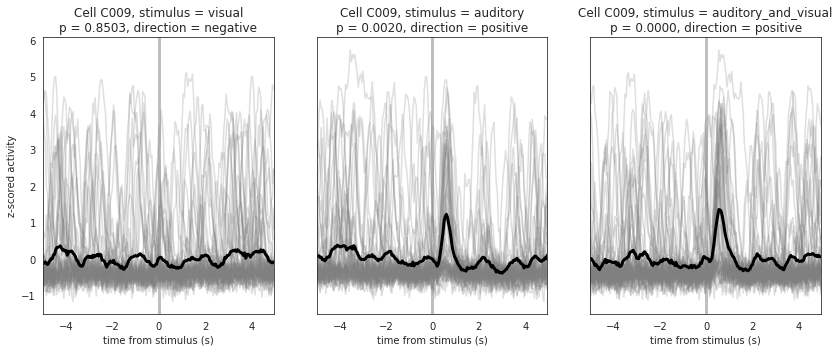

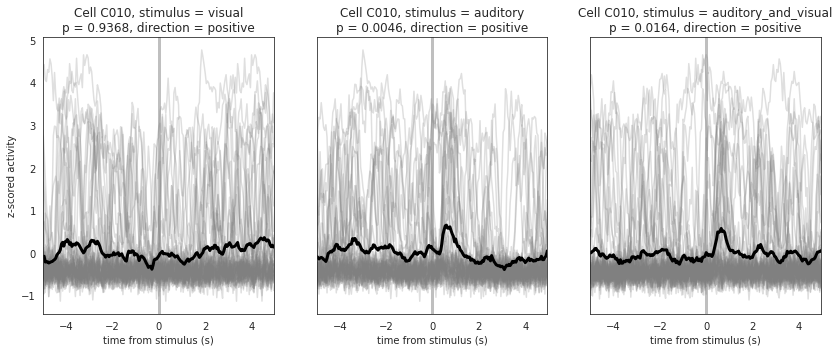

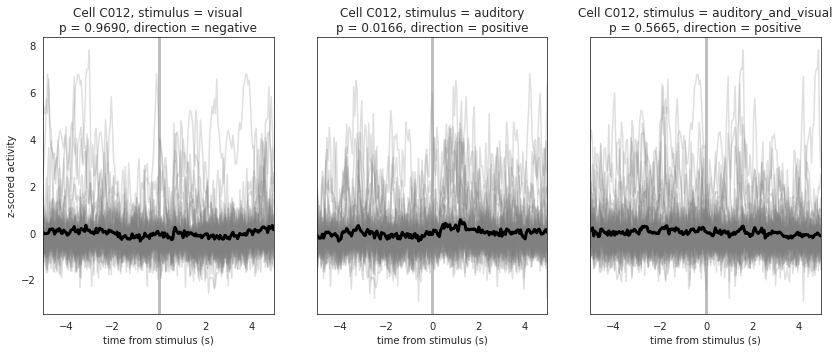

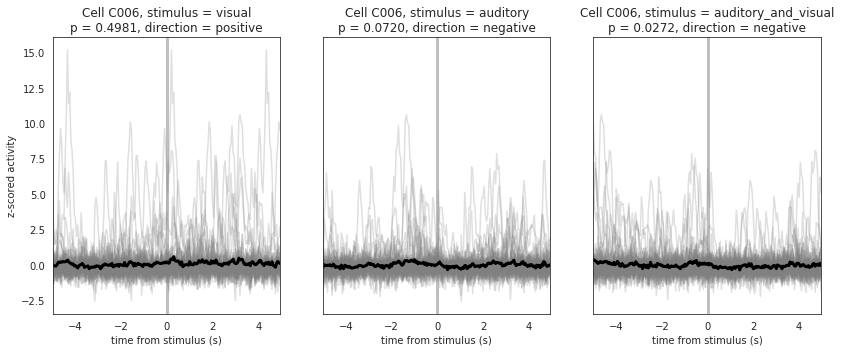

In [23]:
mouse_id = 'M375765'
fig2_helper_functions.plot_cells_with_significant_responses(session[mouse_id]);

#### How dependent is the significance value on the size of the window?
Look at three cells for mouse 375765

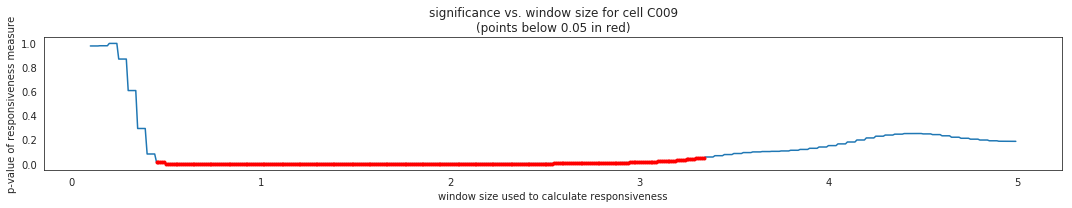

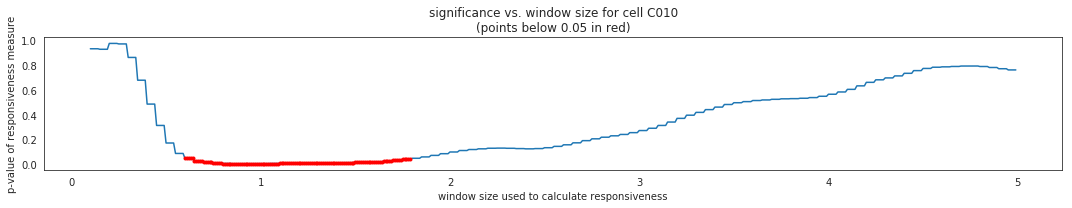

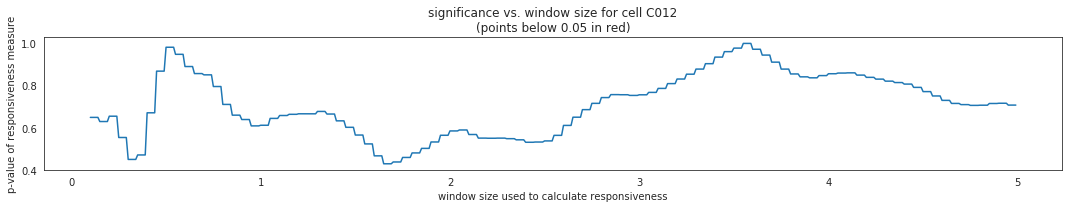

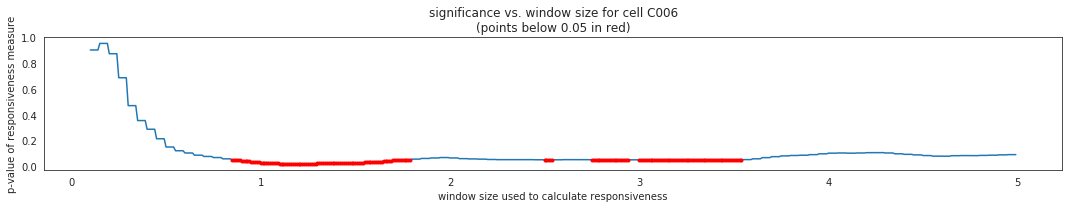

In [24]:
mouse_id = 'M375765'
for cell_id in ['C009','C010','C012','C006']:
    fig,ax=fig2_helper_functions.plot_significance_vs_window_size(mouse_id,cell_id,session)

## what is the overall fraction of responsive cells?

In [46]:
significance_level = 0.05

for mouse_id in mice:
    session[mouse_id].responsive_cells = {}
    responsive_cells = fig2_helper_functions.get_cells_with_significant_responses(session[mouse_id], significance_level=significance_level)
    sessions_to_analyze.at[mouse_id,'number_of_responsive_cells'] = len(responsive_cells)
    for cell_id in responsive_cells:
        session[mouse_id].responsive_cells[cell_id] = {}
        for col,condition in enumerate(['visual','auditory','auditory_and_visual']):
            dat = fig2_helper_functions.get_responses(session[mouse_id],cell_id,condition)
            d = {'trial_{:0>2d}'.format(i):arr for i,arr in enumerate(dat['all_traces'])}
            d['t'] = dat['t']
            session[mouse_id].responsive_cells[cell_id][condition] = pd.DataFrame(d).set_index('t')
    
    
def get_fraction_responsive(row):
    return row['number_of_responsive_cells']/row['cell_count_post_filtering']
sessions_to_analyze['fraction_responsive_cells'] = sessions_to_analyze.apply(get_fraction_responsive, axis=1)

In [47]:
cols_to_display = ['genotype_shorthand','anterior_or_posterior','number_accepted_cells','cell_count_post_filtering','number_of_responsive_cells','fraction_responsive_cells']
sessions_to_analyze[cols_to_display]

,genotype_shorthand,anterior_or_posterior,number_accepted_cells,cell_count_post_filtering,number_of_responsive_cells,fraction_responsive_cells
mouse_id,,,,,,
M334410,Gnb4-Cre;AAB-GCaMPs,anterior,72.0,69,14.0,0.202899
M334412,Gnb4-Cre;AAB-GCaMPs,anterior,146.0,144,1.0,0.006944
M406494,Gnb4-CreERT2;Ai148,anterior,20.0,19,0.0,0.000000
M332849,Gnb4-CreERT2;Ai93,anterior,11.0,11,1.0,0.090909
M397408,Gnb4-CreERT2;Ai93,anterior,17.0,17,2.0,0.117647
M375765,Gnb4-CreERT2;Ai93,anterior,10.0,10,4.0,0.400000
M416531,Gnb4-CreERT2;Ai93,anterior,61.0,61,7.0,0.114754
M432805,Gnb4-CreERT2;Ai93,anterior,45.0,46,3.0,0.065217
M335379,Gnb4-CreERT2;Ai94,anterior,130.0,127,11.0,0.086614


## make some summary plots

#### lump cells together, make an overall summary plot

In [48]:
mice

dict_keys(['M334410', 'M334412', 'M406494', 'M332849', 'M397408', 'M375765', 'M416531', 'M432805', 'M335379', 'M351181'])

In [49]:
responsiveness_summary_all = [pd.DataFrame()]
responsiveness_data_all = [pd.DataFrame()]
for mouse_id in mice:
    mouse_summary = session[mouse_id].responsiveness_summary
    mouse_summary['mouse_id'] = mouse_id
    mouse_summary['location'] = sessions_to_analyze.query('mouse_id == @mouse_id')['anterior_or_posterior'].item()
    
    mouse_data = session[mouse_id].responsiveness_data
    mouse_data['mouse_id'] = mouse_id
    mouse_data['location'] = sessions_to_analyze.query('mouse_id == @mouse_id')['anterior_or_posterior'].item()
    
    responsiveness_summary_all.append(mouse_summary)
    responsiveness_data_all.append(mouse_data)
    
responsiveness_summary_all = pd.concat(responsiveness_summary_all)
responsiveness_data_all = pd.concat(responsiveness_data_all)

def make_unique_cell_id(row):
    return row['mouse_id'] + '_' + row['cell_id']
responsiveness_summary_all['unique_cell_id'] = responsiveness_summary_all.apply(make_unique_cell_id,axis=1)

In [50]:
responsiveness_summary_all['integral_change_magnitude'] = responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
responsiveness_summary_all['mean_change_magnitude'] = responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']

In [51]:
responsiveness_summary_all.head()

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,mouse_id,location,unique_cell_id,integral_change_magnitude,mean_change_magnitude
0,C000,visual,48,1.898550,0.051732,0.635677,-1.0,0.066934,0.002828,0.636036,-1.0,M334410,anterior,M334410_C000,-1.846818,-0.064106
1,C000,auditory,45,1.898550,-3.349861,0.155327,-1.0,0.066934,-0.113877,0.158483,-1.0,M334410,anterior,M334410_C000,-5.248411,-0.180811
2,C000,auditory_and_visual,57,1.898550,-0.810889,0.442163,-1.0,0.066934,-0.025634,0.450141,-1.0,M334410,anterior,M334410_C000,-2.709438,-0.092567
3,C001,visual,48,0.746454,2.100749,0.809431,1.0,0.023552,0.072012,0.799755,1.0,M334410,anterior,M334410_C001,1.354295,0.048460
4,C001,auditory,45,0.746454,-2.576795,0.519665,-1.0,0.023552,-0.088621,0.521200,-1.0,M334410,anterior,M334410_C001,-3.323249,-0.112173


In [52]:
responsiveness_summary_all['mean_change_magnitude'].describe()

count    1857.000000
mean       -0.004192
std         0.124646
min        -0.415598
25%        -0.081974
50%        -0.009931
75%         0.060821
max         0.956843
Name: mean_change_magnitude, dtype: float64

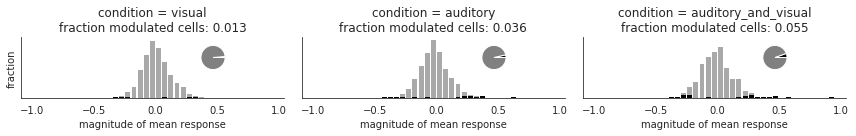

In [53]:
def plot_mod_index_hist(index_vals, significant, ax, bin_edges=np.arange(-1,1,0.05)):
    '''
    index_vals (array of float): values of the index you want to plot
    significant (array of bool): whether each index val is significant or not
    '''
    
    ax.hist([index_vals[significant],index_vals[~significant]], 
             color=['k','darkgrey'], edgecolor='None', stacked=True, 
             bins=bin_edges, rwidth=0.8, normed=True)

significance_threshold = 0.05
fig,ax=plt.subplots(1,3,figsize=(12,2),sharex=True, sharey=True)
for ii,condition in enumerate(['visual','auditory','auditory_and_visual']):
    magnitude = responsiveness_summary_all.query('condition == @condition')['mean_change_magnitude']
    significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
    plot_mod_index_hist(
        magnitude,
        significant,
        ax[ii]
    )
    axins = inset_axes(ax[ii], width="50%", height="50%", loc=1)

    axins.pie(
        [significant.sum(),len(significant)-significant.sum()],
        colors=['black','gray'],
        labels=['','']
    )
    ax[ii].set_title('condition = {}\nfraction modulated cells: {:0.3f}'.format(condition,significant.mean()))
    ax[ii].set_xlabel('magnitude of mean response')
    ax[ii].set_yticks([])
ax[0].set_ylabel('fraction')
sns.despine()
fig.tight_layout()

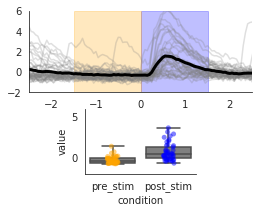

In [54]:
save_fig = False
fig=plt.figure(figsize=(4,3))
ax = []
ax.append(vbp.placeAxesOnGrid(xspan = (0,1),yspan=(0,0.5),fig=fig))
ax.append(vbp.placeAxesOnGrid(xspan = (0.25,0.75),yspan=(0.6,1),fig=fig))

window_size = responsiveness_window

dat = fig2_helper_functions.get_responses(session['M334410'],'C071','auditory')

pre_stim_indices = np.where(np.logical_and(dat['t']>=-window_size,dat['t']<0))
post_stim_indices = np.where(np.logical_and(dat['t']>0,dat['t']<=window_size))

pre_stims = []
post_stims = []
for idx in range(len(dat['all_traces'])):
    pre_stims.append(np.mean(dat['all_traces'][idx][pre_stim_indices]))
    post_stims.append(np.mean(dat['all_traces'][idx][post_stim_indices]))
    
df = pd.DataFrame({
    'value':pre_stims+post_stims,
    'condition':['pre_stim']*len(pre_stims) + ['post_stim']*len(post_stims)
})


vbp.plot_event_triggered_timeseries(dat,ax=ax[0])
ax[0].axvspan(-window_size,0,color='orange',alpha=0.25)
ax[0].axvspan(0,window_size,color='blue',alpha=0.25,zorder=-1)
ax[0].set_xlim(-2.5,2.5)

c=sns.stripplot(
    x='condition',
    y='value',
    data=df,
    ax=ax[1],
    palette=sns.color_palette(['orange', 'blue']),
    alpha=0.5
)
b=sns.boxplot(
    x='condition',
    y='value',
    data=df,
    ax=ax[1],
    palette=sns.color_palette(['gray','gray']),
    whis=np.inf
);
ax[0].set_ylim(-2,6)
ax[1].set_ylim(-2,6)


sns.despine()
fig.tight_layout()

if save_fig:
    vbp.save_figure(fig,fname=os.path.join(savepath,'responsiveness_example'),formats=['.png','.pdf'])


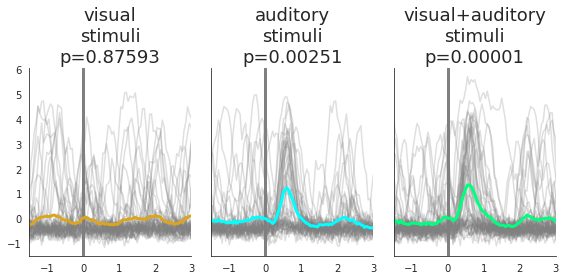

In [55]:
def plot_all(sess,cell_id):

    colors=[
        'goldenrod',
        'cyan',
        'springgreen'
    ]

    titles = [
        'visual\nstimuli\np={:0.5f}',
        'auditory\nstimuli\np={:0.5f}',
        'visual+auditory\nstimuli\np={:0.5f}',
    ]
    
    rs = responsiveness_summary_all.query("mouse_id==@mouse and cell_id==@cell_id")[['condition','p-value_on_means']]

    fig,ax = plt.subplots(1,3,figsize=(8,4),sharex=True,sharey=True)
    for col,condition in enumerate(['visual','auditory','auditory_and_visual']):
        dat = fig2_helper_functions.get_responses(sess,cell_id,condition)
        vbp.plot_event_triggered_timeseries(
            dat,
            ax=ax[col],
            foreground_color=colors[col],
            title=titles[col].format(rs[rs['condition']==condition]['p-value_on_means'].item())
        )
        ax[col].axvline(0,color='k',linewidth=3,zorder=-np.inf,alpha=0.5)
        ax[col].set_xlim(-1.5,3)

    sns.despine()
    fig.tight_layout()
    
    return fig,ax

mouse = 'M375765'
cell_id = 'C009'
fig,ax=plot_all(session[mouse],cell_id)
if save_fig:
    vbp.save_figure(fig,fname=os.path.join(savepath,'passive_sample_mouse={}_cell={}'.format(mouse,cell_id)),formats=['.png','.pdf'])

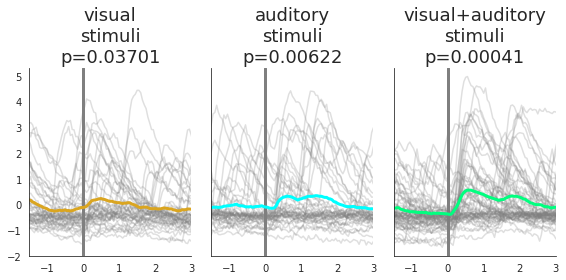

In [56]:
mouse = 'M351181'
cell_id = 'C104'
fig,ax=plot_all(session[mouse],cell_id)
if save_fig:
    vbp.save_figure(fig,fname=os.path.join(savepath,'passive_sample_mouse={}_cell={}'.format(mouse,cell_id)),formats=['.png','.pdf'])

In [57]:
rs = responsiveness_summary_all.query("mouse_id==@mouse and cell_id==@cell_id")[['condition','p-value_on_means']]
rs[rs['condition']=='visual']['p-value_on_means'].item()

0.03700990636345365

In [58]:
responsiveness_summary_all[
    (responsiveness_summary_all['condition']=='auditory')
    &(responsiveness_summary_all['p-value_on_means']<0.05)
]

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,mouse_id,location,unique_cell_id,integral_change_magnitude,mean_change_magnitude
16,C005,auditory,45,-1.942898,5.117109,1.930104e-02,1.0,-0.066439,0.172642,2.004293e-02,1.0,M334410,anterior,M334410_C005,7.060007,0.239081
22,C008,auditory,45,-2.129318,3.891273,4.482177e-02,1.0,-0.071210,0.136996,4.528959e-02,1.0,M334410,anterior,M334410_C008,6.020591,0.208207
28,C011,auditory,45,-2.916706,2.541159,4.486995e-02,1.0,-0.100002,0.084754,4.680615e-02,1.0,M334410,anterior,M334410_C011,5.457866,0.184756
94,C047,auditory,45,-5.492797,12.859002,3.086703e-07,1.0,-0.188876,0.428470,4.650463e-07,1.0,M334410,anterior,M334410_C047,18.351799,0.617346
139,C071,auditory,45,-7.334704,21.206982,2.351120e-14,1.0,-0.251742,0.705101,4.738861e-14,1.0,M334410,anterior,M334410_C071,28.541686,0.956843
145,C075,auditory,45,3.369222,-8.937524,8.677437e-03,-1.0,0.115805,-0.299793,9.879153e-03,-1.0,M334410,anterior,M334410_C075,-12.306745,-0.415598
163,C095,auditory,45,2.823904,-8.712308,9.891319e-03,-1.0,0.096902,-0.296900,1.055437e-02,-1.0,M334410,anterior,M334410_C095,-11.536212,-0.393801
184,C115,auditory,45,2.558649,-5.908439,2.382780e-02,-1.0,0.087017,-0.198577,2.648651e-02,-1.0,M334410,anterior,M334410_C115,-8.467089,-0.285594
172,C060,auditory,51,0.125019,10.519674,1.247823e-02,1.0,0.004189,0.362993,1.219231e-02,1.0,M334412,anterior,M334412_C060,10.394655,0.358804
10,C003,auditory,38,-0.699893,9.399167,3.430790e-02,1.0,-0.024201,0.316238,3.626954e-02,1.0,M332849,anterior,M332849_C003,10.099060,0.340438
